In [14]:
from __future__ import division

from sys import stdout

import numpy as np
import networkx as nx
import sklearn.metrics as met
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt

from itertools import repeat

from Queue import Queue
from threading import Thread
from threading import current_thread

MIN_EXPANSION_SIZE = 10
MAX_DELETED_NEURONS = 3

#########################################################################################################################

##function to visualise graph
def visualise_graph(G, colours, layer):
        
    ## create new figure for graph plot
    fig, ax = plt.subplots()
    
    # graph layout
    pos = nx.spring_layout(G)
    
    #attributes in this graph
    attributes = np.unique([v for k, v in nx.get_node_attributes(G, "assigned_community_layer_{}".format(layer)).items()])

    # draw nodes -- colouring by cluster
    for i in range(min(len(colours), len(attributes))):
       
        node_list = [n for n in G.nodes() if G.node[n]["assigned_community_layer_{}".format(layer)] == attributes[i]]
        colour = [colours[i] for n in range(len(node_list))]
        
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=colour)
        
    #draw edges
    nx.draw_networkx_edges(G, pos)

    # draw labels
    nx.draw_networkx_labels(G, pos)
    
    #title of plot
    plt.title('Nodes coloured by cluster, layer: {}'.format(layer))

    #show plot
    plt.show()

## visualise graph based on network clusters
def visualise_network(network, colours, layer):
    
    #num neurons in lattice
    num_neurons = len(network)

    ##create new figure for lattice plot
    fig, ax = plt.subplots()
    
    # graph layout
    pos = nx.spring_layout(network)

    # draw nodes -- colouring by cluster
    for i in range(len(colours)):
        nx.draw_networkx_nodes(network, pos, nodelist = [network.nodes()[i]], node_color = colours[i])

    #draw edges
    nx.draw_networkx_edges(network, pos)

    # draw labels
    nx.draw_networkx_labels(network, pos)
    
    #label axes
    plt.title('Neurons in lattice, layer: '+str(layer))
    
    #show lattice plot
    plt.show()

##########################################################################################################################

def initialise_weight(G):
    
    n = G.nodes()[np.random.randint(len(G))]
    
    neighbours = G.neighbors(n)
    
    m = neighbours[np.random.randint(len(neighbours))]
    
    return n, m, np.random.rand()

#function to generate real valued som for graph input
#three initial nodes
def initialise_network(ID, G, starting_nodes=3):
    
    #network will be a one dimensional list
    network = nx.Graph(ID = ID)
    
    #initialise a network with just one neuron
    network.add_nodes_from(range(1, starting_nodes + 1))
    
    #id of nodes
    for n in network.nodes():
        network.node[n]["ID"] = "{}-{}".format(ID, str(n).zfill(2))
        
    #connect nodes     
    for i in range(1, starting_nodes + 1):
        for j in range(i + 1, starting_nodes + 1):
            network.add_edge(i, j)
    
    V = np.array([initialise_weight(G) for i in range(starting_nodes)])
    
    #return network
    return network, V

#########################################################################################################################

def precompute_sigmas(sigma, num_epochs):
    
    return np.array([sigma * np.exp(-2 * sigma * e / num_epochs)
                     for e in range(num_epochs)])

##########################################################################################################################
##TODO
# function to train SOM on given graph
def train_network(G, network, V, num_epochs, eta_0, precomputed_sigmas, 
                  precomputed_graph_shortest_paths, precomputed_graph_shortest_path_lengths):
    
    #initial learning rate
    eta = eta_0
    
    #list if all patterns to visit
    training_patterns = range(len(G))
    
    #shortest path matrix
    shortest_path = np.array(nx.floyd_warshall_numpy(network))
    
    for e in range(num_epochs):
        
        #shuffle nodes
        np.random.shuffle(training_patterns)
        
        sigma = precomputed_sigmas[e]
        
        # iterate through N nodes of graph
        for i in training_patterns:
            
            #data point to consider
            x = G.nodes()[i]
            
            #determine winning neuron
            closest_neuron = winning_neuron(x, V, precomputed_graph_shortest_path_lengths)
            
            # update weights
            V = update_weights(x, V, closest_neuron, shortest_path[closest_neuron], eta, precomputed_sigmas[e],
                              precomputed_graph_shortest_paths, precomputed_graph_shortest_path_lengths)

    return V
        
##########################################################################################################################

def distance(x, v, precomputed_graph_shortest_path_lengths):
    beta = np.float(v[2])
    return min(precomputed_graph_shortest_path_lengths[v[0]][x] + beta, 
               precomputed_graph_shortest_path_lengths[v[1]][x] + 1 - beta)

# winning neuron
def winning_neuron(x, V, precomputed_graph_shortest_path_lengths):
    
    distances = np.array([distance(x, v, precomputed_graph_shortest_path_lengths) for v in V])
    
    return distances.argmin()

##########################################################################################################################


# function to update weights
def update_weights(x, V, winning_neuron, shortest_path_length, eta, sigma, 
                   precomputed_graph_shortest_paths, precomputed_graph_shortest_path_lengths):
    
    #weight update (vectorised)
    deltaV = np.dot(np.diag(eta * np.exp(- shortest_path_length ** 2 / (2 * sigma ** 2))), 
                      np.array([distance(x, v, precomputed_graph_shortest_path_lengths) for v in V]))
    
    V = np.array([move_along_shortest_path(x, v, deltav, precomputed_graph_shortest_paths,
                                           precomputed_graph_shortest_path_lengths) for v, deltav in zip(V, deltaV)])
    
    return V
                                 
                                 
def move_along_shortest_path(x, v, deltaV, precomputed_graph_shortest_paths, 
                             precomputed_graph_shortest_path_lengths):
    
    #unpack v
    vi, vj, beta = v
    beta = np.float(beta)
    
    # four cases to consider
    if precomputed_graph_shortest_path_lengths[x][vi] + \
    beta * precomputed_graph_shortest_path_lengths[vi][vj] < \
    precomputed_graph_shortest_path_lengths[x][vj] + (1 - beta) * precomputed_graph_shortest_path_lengths[vi][vj]:
        
        # moving towards vi
        #two cases here -- do we stay within (vi,vj) or move to next node?
        
        if deltaV < beta * precomputed_graph_shortest_path_lengths[vi][vj]:
            
            # can safely move towards vi
            new_beta = (beta * precomputed_graph_shortest_path_lengths[vi][vj] - deltaV) / \
            precomputed_graph_shortest_path_lengths[vi][vj]
            
            return vi, vj, new_beta
        
        else:
            
            # we are moving towards vi but have passed it -- so now we must adjust vi, vj and beta
            
            # finding new vi and vj
            # how far past vi have we moved?
            d = deltaV - beta * precomputed_graph_shortest_path_lengths[vi][vj]
            
            # next, we will find the next node in the shortest path 
            path = precomputed_graph_shortest_paths[vi][x]
            
            i = 0;
            # vj will be second on the shortest path from vi to x
            new_vi = path[i]
            new_vj = path[min(i+1, len(path) - 1)]
            
            # keep moving vi and vj along path until remaining distance to move (d)
            # is less than dist[new_vi][new_vj]
            while d > precomputed_graph_shortest_path_lengths[new_vi][new_vj]:
                
                #reached target
                if new_vi == x or new_vj == x:
                    
                    # set weight to be input vector
                    
                    #set new vi to be input vector
                    new_vi = x
                    
                    new_vj = x
                    
                    d = 0
                    
                    break
                
                # subtract distance between vi and vj
                d -= precomputed_graph_shortest_path_lengths[new_vi][new_vj]
                
                # increment i
                i += 1
                
                # update vi, vj
                new_vi = path[i]
                new_vj = path[i+1]
                
            # now d < dist[new_vi][new_vj]
            
            # calculate new beta 
            #new_beta = (distance_function(new_vi, v) + beta * \
            #            dist[vi][vj] - move_distance) / distance_function(new_vi, v)
            new_beta = d / precomputed_graph_shortest_path_lengths[new_vi][new_vj]
            
            return new_vi, new_vj, new_beta
            
    else:

        #moving towards vj
        #two cases here -- do we stay within (vi,vj) or move to next node?

        if deltaV < (1 - beta) * precomputed_graph_shortest_path_lengths[vi][vj]:

            #can move safely towards vj
            new_beta = (beta * precomputed_graph_shortest_path_lengths[vi][vj] + deltaV) / \
            precomputed_graph_shortest_path_lengths[vi][vj]

            return vi, vj, new_beta

        else:

            # we are moving towards vj but have passed it -- so now we must adjust vi, vj and beta

            # finding vi and vj
            # how far past vj have we moved?
            d = deltaV - (1 - beta) * precomputed_graph_shortest_path_lengths[vi][vj]

            # next, we will find the next node in the shortest path 
            path = precomputed_graph_shortest_paths[vj][x]

            # initialise list index i
            i = 0;
            
            # vj will be second on the shortest path from vj to x
            new_vi = path[i]
            new_vj = path[min(i+1, len(path) - 1)]

            # keep moving vi and vj along path until remaining distance to move (d)
            # is less than dist[new_vi, new_vj]
            while d > precomputed_graph_shortest_path_lengths[new_vi][new_vj]:
                
                #reached target
                if new_vi == x or new_vj == x:
                    
                    # set weight to be input vector
                    
                    #set new vi to be input vector
                    new_vi = x
                    
                    #
                    new_vj = x
                    
                    #
                    d = 0
                    
                    break

                #subtract distance between vi and vj
                d -= precomputed_graph_shortest_path_lengths[new_vi][new_vj]

                # increment i
                i += 1
                
                # move vi and vj along path
                new_vi = path[i]
                new_vj = path[i+1]

            # now d < dist[new_vi, new_vj]

            # calculate new beta 
            #new_beta = (distance_function(new_vi, v) + (beta) * \
            #            dist[vi][vj] - move_distance) / distance_function(new_vi, v)
            new_beta = d / precomputed_graph_shortest_path_lengths[new_vi][new_vj]

        return new_vi, new_vj, new_beta

########################################################################################################################   
                                 

                                 
# assign nodes into clusters
def assign_nodes(G, network, V, precomputed_graph_shortest_path_lengths):
    
    #distance from each datapoint (row) to each weight vector (column)
    distances = np.array([[distance(x, v, precomputed_graph_shortest_path_lengths) for v in V] for x in G.nodes()])
    
    #minium distance for each datapoint
    min_distances = np.min(distances, axis=1)
    
    #index of column giving minimum distance
    arg_min_distances = np.argmin(distances, axis=1)
    
#     print "ARG MIN DISTANCES"
#     print arg_min_distances
    
    #nodes corresponding to minimum index (of length len(X))
    minimum_nodes = np.array([network.nodes()[n] for n in arg_min_distances])
    
#     print "MINIMUM NODES"
#     print minimum_nodes
    
    #list of neurons with no assignments
    empty_neurons = np.array([n for n in network.nodes() if n not in minimum_nodes])
    
    if empty_neurons.size > 0:
    
        ################################################DELETION####################################################

        #neighbours of deleted neurons
        neighbour_lists = np.array([network.neighbors(n) for n in empty_neurons])
        
#         print "DELETING NODES: {}".format(empty_neurons)
        
        #remove the nodes
        network.remove_nodes_from(empty_neurons)
        
        ##remove from V
        V = np.array([V[i] for i in range(len(V)) if i in arg_min_distances])
        
        #compute distances between all neurons in input space
        computed_neuron_distances = compute_euclidean_distances(network, V, precomputed_graph_shortest_path_lengths)
        
        ##connect separated components
        for neighbour_list in neighbour_lists:
            connect_components(network, neighbour_list, computed_neuron_distances)

        ############################################################################################################

    #array of errors
    errors = np.array([np.mean(min_distances[minimum_nodes == n]) for n in network.nodes()])
    
#     print "ERRORS"
#     print errors
    
    #compute MQE
    MQE = np.mean(errors)
    
#     print "MQE={}, size of map={}".format(MQE, len(network))
    
    ##array of assignments
    assignments = np.array([np.array([G.nodes()[i] for i in np.where(minimum_nodes == n)[0]]) for n in network.nodes()])
    
#     print "NAMES"
#     print names
    
#     print "ASSIGNMENTS"
#     print assignments
    
    #zip zith nodes
    errors = {n: e for n, e in zip(network.nodes(), errors)}
    assignments = {n: a for n, a in zip(network.nodes(), assignments)}
    
    print "ERRORS"
    print errors
    print
    
    print "ASSIGNMENTS"
    print assignments
    print
    
    nx.set_node_attributes(network, "e", errors)
    nx.set_node_attributes(network, "ls", assignments)
    
    return MQE, empty_neurons.size, V

##########################################################################################################################

def neuron_distances(v1, v2, precomputed_graph_shortest_path_lengths):
    beta = np.float(v1[2])
    return min(distance(v1[0], v2, precomputed_graph_shortest_path_lengths) + beta,
              distance(v1[1], v2, precomputed_graph_shortest_path_lengths) + 1 - beta)
                                 
                                 
def compute_euclidean_distances(network, V, precomputed_graph_shortest_path_lengths):
    
    distances = np.array([[neuron_distances(v1, v2, precomputed_graph_shortest_path_lengths) for v2 in V] for v1 in V])
    
    return {network.nodes()[i] : {network.nodes()[j] : distances[i, j] for j in range(len(distances[i]))}
           for i in range(len(distances))}
    
######################################################################################################################### 


def connect_components(network, neighbour_list, computed_neuron_distances):
    
    sub_network = network.subgraph(neighbour_list)
    
    connected_components = [sub_network.subgraph(c) for c in nx.connected_components(sub_network)]
    number_of_connected_components = len(connected_components)
    
    for i in range(number_of_connected_components):
        
        connected_component_1 = connected_components[i].nodes()
        
        for j in range(i + 1, number_of_connected_components):
            
            connected_component_2 = connected_components[j].nodes()
            
            distances = np.array([[computed_neuron_distances[n1][n2] for n2 in connected_component_2]
                                 for n1 in connected_component_1])
            
            min_n1, min_n2 = np.unravel_index(distances.argmin(), distances.shape)
            
            network.add_edge(connected_component_1[min_n1], 
                            connected_component_2[min_n2])

##########################################################################################################################
            
##function to identify neuron with greatest error
def identify_error_unit(network):
    
    errors = nx.get_node_attributes(network, "e")
    
    return max(errors, key=errors.get)

##########################################################################################################################

def expand_network(ID, G, network, V, error_unit, precomputed_graph_shortest_path_lengths):
    
    #v goes to random vector in range of error unit
    ls = network.node[error_unit]["ls"]    
    w = initialise_weight(G.subgraph(ls))
    
    #zip nodes and distances
    distances = zip(network.nodes(), np.array([neuron_distances(w, v, 
                    precomputed_graph_shortest_path_lengths) for v in V]))
        
    #identify neighbour pointing closet
    error_unit_neighbours = network.neighbors(error_unit)
    
    
    #id of new node
    new_node = max(network) + 1
    
    #add new node to map
    network.add_node(new_node)
    
    ##id
    network.node[new_node]["ID"] = "{}-{}".format(ID, str(new_node).zfill(2))
    
    #add edges to map
    
    #connect error unit and new node
    network.add_edge(error_unit, new_node)
    
    if len(error_unit_neighbours) > 0:
        
        ##find closest neighbour
        distances = {n: v for n, v in distances if n in error_unit_neighbours}
        closest_neighbour = min(distances, key=distances.get)
        
        #connect to error unit and closest neighbour
        network.add_edge(closest_neighbour, new_node)
        
    #add v to V
    V = np.vstack([V, w])   
    
    return V
        
##########################################################################################################################
##########################################################################################################################

##GHSOM algorithm
def ghsom(ID, G, lam, eta, sigma, e_0, e_sg, e_en, q):
    
    print "MQE_0={}, growth target={}".format(e_0, e_0 * e_sg)
    
    precomputed_graph_shortest_paths = nx.shortest_path(G)
    precomputed_graph_shortest_path_lengths = {n1 : 
            {n2 : len(precomputed_graph_shortest_paths[n1][n2]) for n2 in precomputed_graph_shortest_paths.keys()}
                                              for n1 in precomputed_graph_shortest_paths.keys()}
    
    print "computed shortest paths"
    
    if e_0 == np.inf:
        starting_nodes = 1
    else:
        starting_nodes = 3
        
    #create som for this neuron
    network, V = initialise_network(ID, G, starting_nodes=starting_nodes)
    
    print "initialised network"
    
    #precompute sigmas
    precomputed_sigmas = precompute_sigmas(sigma, lam)
    
    print "precomputed sigmas"
    
    #train for lamda epochs
    V = train_network(G, network, V, lam, eta, precomputed_sigmas, precomputed_graph_shortest_paths,
                      precomputed_graph_shortest_path_lengths)
    
    print "trained network"
    print V
    
    #classify nodes and compute error
    MQE, num_deleted_neurons, V = assign_nodes(G, network, V, precomputed_graph_shortest_path_lengths)
    
    print "assigned nodes MQE={}".format(MQE)
    
    ##som growth phase
    #repeat until error is low enough
    while MQE > e_sg * e_0 and num_deleted_neurons < MAX_DELETED_NEURONS:
        
        #find neuron with greatest error
        error_unit = identify_error_unit(network)
        
        print "identified error unit: {}".format(error_unit)
        
        #expand network
        V = expand_network(ID, G, network, V, error_unit, precomputed_graph_shortest_path_lengths)
        
        print "expanded network"
        
        #train for lam epochs
        V = train_network(G, network, V, lam, eta, precomputed_sigmas, precomputed_graph_shortest_paths,
                      precomputed_graph_shortest_path_lengths)
        
        print "trained network"
        print V

        #calculate mean network error
        MQE, deleted_neurons, V = assign_nodes(G, network, V, precomputed_graph_shortest_path_lengths)
        num_deleted_neurons += deleted_neurons
        
        print "assigned nodes MQE={}".format(MQE)
        
    print "growth terminated, MQE: {}, target: {}, number of deleted neurons: {}".format(MQE, e_0 * e_sg, num_deleted_neurons)
        
    ##neuron expansion phase
    #iterate thorugh all neruons and find neurons with error great enough to expand
    for _, d in network.nodes(data=True):
        
        #unpack
        node_id = d["ID"]
        ls = d["ls"]
        e = d["e"]
        
        #check error
        if e_0 == np.inf or (e > e_en * e_0 and len(ls) > MIN_EXPANSION_SIZE and num_deleted_neurons < MAX_DELETED_NEURONS):
            
            if e_0 == np.inf:
                node_id = "01"
                
            H = G.subgraph(ls)
            
            print "submitted job: ID={}, e={}, number of nodes={}".format(node_id, e, len(ls))
            
            #add these parameters to the queue
            q.put((node_id, H, lam, eta, sigma, e, e_sg, e_en))
    
    #return network
    return network, MQE

##########################################################################################################################
##########################################################################################################################

def label_nodes(G, networks):
    
    for _, network, _ in networks: 
        
        for _, d in network.nodes(data=True):
            
            community = d["ID"]
            layer = community.count("-")
            assignment_string = "assigned_community_layer_{}".format(layer)
            
            for node in d["ls"]:
                
                G.node[node][assignment_string] = community


##########################################################################################################################

def NMI_one_layer(G, label, layer):
    
    #actual community for this layer
    actual_community_labels = np.array([v for k, v in nx.get_node_attributes(G, label).items()])
    
    #predicted communitiy for this layer
    predicted_community_labels = np.array([v for k, v in nx.get_node_attributes(G, 
         "assigned_community_layer_{}".format(layer)).items()])

    print actual_community_labels
    print predicted_community_labels
    
    return met.normalized_mutual_info_score(actual_community_labels, predicted_community_labels)

def NMI_all_layers(G, labels):
    
    return np.array([NMI_one_layer(G, labels[i], i + 1) for i in range(len(labels))])

##########################################################################################################################

## get embedding TERRIBLE but staying
def get_embedding(G):
    
#     #get number of niodes in the graph
#     num_nodes = nx.number_of_nodes(G)
    
#     #dimension of embedding
#     dim = 0
#     while 'embedding'+str(dim) in G.node[G.nodes()[0]]:
#         dim += 1
    
#     #initialise embedding
#     X = np.array([[d["embedding{}".format(j)] for j in range(dim)] for n, d in G.nodes(data=True)])

    return np.array([v for k, v in nx.get_node_attributes(G, "embedding").items()])


##########################################################################################################################

def process_job(q, networks):
    
    #unpack first element of queue
    #contains all the para,eters for GHSOM
    ID, G, lam, eta, sigma, e_0, e_sg, e_en = q.get()

    #run GHSOM and return a network and MQE
    n, e = ghsom(ID, G, lam, eta, sigma, e_0, e_sg, e_en, q)

    #append result to networks list
    networks.append((ID, n, e))

    #mark task as done
    q.task_done()

def worker(q, networks):
    
    #continually poll queue for jobs 
    while True:
        process_job(q, networks)

def main(params, filename, lam=10000, num_threads=1):
    
    #network
    G = nx.read_gpickle(filename)
    
    ##list of returned networks
    networks = []
    
    #initilise worker queue
    q = Queue()
    
    #add initial layer of ghsom to queue
    q.put(("00", G, lam, params["eta"], params["sigma"], np.inf, params["e_sg"], params["e_en"]))
    
    if num_threads > 1:
    
        #initialise threads
        for i in range(num_threads):

            t = Thread(target=worker, args=(q, networks))
            t.setDaemon(True)
            t.start()

        #finally wait until queue is empty and all tasks are done
        q.join()
        
    else :
        
        #single thread
        while not q.empty():
            process_job(q, networks)
    
    print "DONE"
    
    return G, networks

In [15]:
params = {'eta': 0.001,
         'sigma': 1,
          'e_sg': 0.6,
         'e_en': 1.0}

In [ ]:
G, networks = main(params=params, filename="embedded_benchmark.gpickle", num_threads=5, lam=1000)

MQE_0=inf, growth target=inf
computed shortest paths
initialised network
precomputed sigmas
trained network
[[u'241' u'163' u'0.000246208749352']]
ERRORS
{1: 4.4181072424215095}

ASSIGNMENTS
{1: array([u'216', u'217', u'214', u'215', u'212', u'213', u'210', u'211',
       u'165', u'218', u'219', u'133', u'132', u'131', u'130', u'137',
       u'136', u'135', u'134', u'95', u'139', u'138', u'166', u'24', u'25',
       u'26', u'27', u'20', u'21', u'22', u'23', u'223', u'28', u'29',
       u'222', u'4', u'8', u'220', u'120', u'121', u'122', u'123', u'124',
       u'125', u'126', u'127', u'128', u'129', u'167', u'91', u'59', u'58',
       u'55', u'54', u'57', u'56', u'51', u'50', u'53', u'52', u'16',
       u'145', u'164', u'93', u'199', u'198', u'200', u'195', u'194',
       u'197', u'196', u'191', u'190', u'193', u'192', u'115', u'252',
       u'88', u'89', u'111', u'110', u'113', u'176', u'82', u'83', u'80',
       u'81', u'86', u'87', u'84', u'85', u'251', u'140', u'173', u'206',
      

In [4]:
label_nodes(G, networks[1:])

In [5]:
NMI_all_layers(G, labels=["firstlevelcommunity"])

['10' '17' '17' '6' '6' '17' '2' '2' '10' '3' '20' '18' '10' '2' '5' '19'
 '9' '12' '24' '16' '5' '15' '15' '12' '22' '12' '16' '22' '12' '6' '16'
 '6' '20' '16' '24' '3' '17' '8' '21' '21' '18' '9' '15' '24' '10' '23'
 '12' '17' '8' '11' '15' '23' '13' '4' '23' '15' '18' '21' '13' '7' '1'
 '10' '6' '3' '9' '6' '10' '3' '2' '18' '18' '18' '24' '9' '7' '19' '10'
 '1' '5' '22' '20' '21' '21' '4' '11' '5' '16' '7' '7' '9' '6' '14' '22'
 '17' '7' '23' '3' '13' '8' '3' '7' '17' '14' '14' '19' '14' '3' '3' '3'
 '3' '5' '22' '8' '4' '1' '14' '18' '8' '1' '20' '4' '19' '4' '7' '1' '3'
 '11' '11' '16' '10' '20' '23' '15' '1' '11' '16' '5' '9' '14' '24' '3'
 '14' '6' '2' '24' '1' '14' '2' '14' '23' '21' '8' '21' '18' '20' '20' '14'
 '14' '21' '2' '2' '23' '10' '1' '19' '9' '1' '21' '8' '14' '10' '19' '8'
 '16' '1' '17' '17' '23' '17' '5' '12' '4' '11' '20' '11' '12' '1' '4' '15'
 '9' '20' '23' '6' '22' '22' '5' '18' '21' '2' '24' '17' '24' '19' '22'
 '10' '17' '10' '14' '14' '3' '3' '10' '14' '3

array([ 0.59985896])

In [12]:
_, network, _ = networks[0]
colours = np.random.rand(len(network), 3)

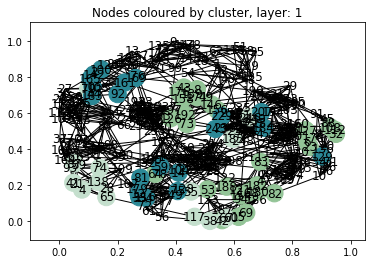

In [13]:
visualise_graph(G=G, colours=colours, layer=1)

In [8]:
len(G)

256

In [11]:
for _, network, _ in networks:
    
    len(network)
    
#     for n, d in network.nodes(data=True):
        
#         print d["ls"]

3

6

7

9